In [1]:
%%capture
# !pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121
# !pip install pytorch_lightning==2.1
# !pip install pandas librosa opencv-python matplotlib  #cupy-cuda110 
# !pip install -U albumentations
# import timm 

In [2]:
import pandas as pd
import os
import torch
from IPython.display import display, Audio
import librosa
import math
import numpy as np
import scipy
from scipy import signal as sci_signal
import cv2
import matplotlib.pyplot as plt
import gc
import sys
import numpy as np
from glob import glob
from tqdm import tqdm
import pytorch_lightning as pl
import albumentations as albu
from torchvision.models import efficientnet
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pandas as pd
import pandas.api.types
import sklearn.metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from torch.utils.data import WeightedRandomSampler

mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}
def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V
        

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype  for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

In [5]:
class CONFIG:
    
    # == GENERAL ==
    seed = 123                             # random seed
    device = 'cuda'                         # device to be used
    mix_precision = False                   # whether to use mixed-16 precision
    
    # == DATA ==
    preprocess = True
    preprocessed_data = '../../preprocessed_data/imgs_v0/'                  # Path for processed data to be stores (Must put on .gitignore to not send to repo)
    checkpoint_dir = '../chpks/TO_SUBMIT_TSC_XCA_CLEAN_NOVALID_CE'  # Checkpoints path (Must put on .gitignore to not send to repo)
    data_dir_2024 = '../../data/2024'# root folder
    sr = 32000                              # sampling rate
    n_fft = 1095                            # NFFT of Spec.
    win_len = 412                          # WIN_SIZE of Spec.
    hop_len = 100                         # overlap of Spec.
    min_freq = 40                           # min frequency
    max_freq = 15000                        # max frequency
    
    # == MODEL ==
    model = 'efficientnet_b0'               # model architecture
    
    # == DATASET ==
    batch_size = 32                         # batch size of each step
    n_workers = 4                           # number of workers
    
    # == AUG ==
    USE_HORIZFLIP = True
    USE_XYMASKING = True                    # whether use XYMasking

    # == TRAINING ==
    folds = 1                              # n fold
    epochs = 10                             # max epochs
    epochs_stage_1 = 5
    epochs_stage_2 = 10
    lr = 1e-3                               # learning rate
    weight_decay = 1e-2                     # weight decay of optimizer
    visualize = True                        # whether to visualize data and batch

In [6]:
df = pd.read_csv("2024_with_30sec_slices.csv")
df.head()

# Labels
label_list = sorted(df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

train_df = df[['primary_label', 'sliced_path','wav_path','secondary_labels','rating']].copy()  # Uses only audio, label and rating.

# Create Target
train_df['target'] = train_df.primary_label.map(label2id)

# Create Filepath
# train_df['filepath'] = CONFIG.data_dir_2024 + '/train_audio/' + train_df.filename

# Create Name
train_df['name'] = train_df.wav_path.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

In [7]:
import torchaudio
def preprocess_fn(filepath, input_audio = None):

    if(input_audio is not None):
        waveform = input_audio
    else:
    # LOAD .OGG
        waveform, sample_rate = torchaudio.load(filepath, normalize=True)
        # waveform = waveform[:5*sample_rate]

    # print(len(waveform.shape))
    # if(len(waveform.shape) < 2):
        # waveform
    
    transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
    spectrogram = transform(waveform)
    db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
    spectrogram = db_transform(spectrogram)

    # print(spectrogram.shape)
    spec_data = normalize_melspec(spectrogram).squeeze(0) 
    # spec_data = spec_data.expand(3, -1, -1).permute(1, 2, 0).numpy()
    
    # print(spec_data.shape)
    # spec_data = albu.Resize(256, 256)(image=spec_data)
    # spec_data = albu.Normalize()(image=spec_data['image'])['image'].astype(np.float32)
    # spec = res['image'].astype(np.float32)
    # spec_data = spec_data.transpose(2, 0, 1)
    # print(spec_data['image'].shape)
    return spec_data

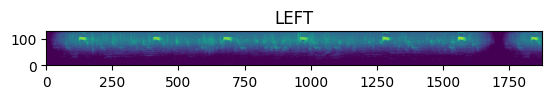

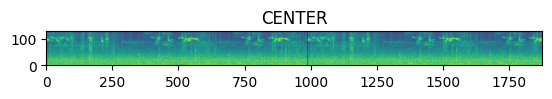

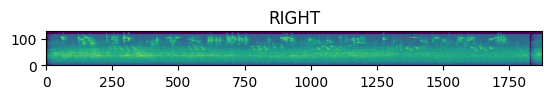

In [8]:
# Just testing

processed_spec_left = preprocess_fn(train_df['sliced_path'].values[0])
processed_spec_center = preprocess_fn(train_df['sliced_path'].values[1])
processed_spec_right = preprocess_fn(train_df['sliced_path'].values[2])

plt.figure()
plt.title('LEFT')
plt.imshow(processed_spec_left, origin='lower')
plt.show()

plt.figure()
plt.title('CENTER')
plt.imshow(processed_spec_center, origin='lower')
plt.show()

plt.figure()
plt.title("RIGHT")
plt.imshow(processed_spec_right, origin='lower')
plt.show()

In [9]:
processed_spec_center.shape, processed_spec_center.mean(), processed_spec_center.min()

(torch.Size([128, 1876]), tensor(0.5328), tensor(0.))

In [10]:
import torchaudio.transforms as T
import torchaudio
import numpy

In [11]:
import random
class BackgroundAugmentation(object):
    def __init__(self, min_scale, max_scale, back_df, mode = 'train'):
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.backgrounds = back_df
        self.mode = mode

    def __call__(self, waveform):
        numero_aleatorio = random.randint(0, len(self.backgrounds)-1)
        noise_path = self.backgrounds.sliced_path.values[numero_aleatorio]
        noise, sample_rate = librosa.load(noise_path, sr = None)

        # Getting 5 seconds through a p.05 selfmixup
        rand_scale = random.uniform(0, 1)
        ridx = random.randint(0, 5)
        # if(rand_scale > 0.5):
        #     wave = selfmixup(data=noise.reshape(-1, 5*32000), alpha=0.95)
        #     noise = wave[ridx:ridx+1, :][0]

        # else:
        noise = noise[ridx*32000:(ridx+5)*32000]
            
        
        # noise = np.concatenate([noise]*3) #if training with 15sec
            
        rand_scale = random.uniform(self.min_scale, self.max_scale)
#         print(rand_scale)
        noisy_speech = (rand_scale * waveform + noise) / (1+rand_scale)
#         print(waveform.mean(), noisy_speech.mean())
        return noisy_speech

In [12]:
def selfmixup(data, alpha):
    
    data = torch.tensor(data)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    # shuffled_targets = targets[indices]
    #print(indices)
    lam = np.random.beta(alpha, alpha)
    # print(lam)
    #print(lam)
    new_data = data * lam + shuffled_data * (1 - lam)
    # new_targets = targets * lam + shuffled_targets * (1 - lam)
    return new_data.numpy()

In [13]:
# list_augs = os.listdir('../../preprocessed_data/5sec_unlabeleds_center/')
# list_augs = ['../../preprocessed_data/5sec_unlabeleds_center/' + w for w in list_augs]

# ex_df = pd.DataFrame({'wav_path': list_augs})
ex_df = pd.read_csv('2024_unlabelled_with_30sec_slices.csv')

In [14]:

backaud = BackgroundAugmentation(0.1,0.1, ex_df, mode = 'train')

In [15]:
train_df.head(2)

,primary_label,sliced_path,wav_path,secondary_labels,rating,target,name
0,asbfly,../../preprocessed_data/2024_30sec/data_2024_t...,../../data/2024/train_audio/asbfly/XC134896.ogg,[],5.0,0,..-XC134896
1,asbfly,../../preprocessed_data/2024_30sec/data_2024_t...,../../data/2024/train_audio/asbfly/XC164848.ogg,[],2.5,0,..-XC164848


In [16]:
ex = train_df['sliced_path'].values[3]
waveform, sample_rate = librosa.load(ex, sr = None)
print(len(waveform)/sample_rate, sample_rate)
waveform = backaud(waveform[:5*32000])
Audio(waveform, rate = sample_rate)

30.0 32000


In [17]:
ex_df_train, ex_df_val = train_test_split(ex_df, test_size = 0.2, random_state = 42)

In [18]:
y , sr = librosa.load(train_df.sliced_path[0], sr = None)
print(sr, y.shape)
wave = selfmixup(data=y.reshape(-1, 5*32000), alpha=0.95)

32000 (960000,)


In [19]:
import random
class SumMixUp(object):
    def __init__(self, df, labels, min_pct= 0.3, max_pct=1):
        self.df = df
        self.labels = labels
        self.min_pct = min_pct
        self.max_pct = max_pct

    def __call__(self, waveform, label):
        idx = random.randint(0, len(self.df)-1)
        noise_path = self.df.sliced_path.values[idx]
        random_wav, sample_rate = librosa.load(noise_path, sr = None)

        #dont need it here
        # # Getting 5 seconds through a p.05 selfmixup
        # rand_scale = random.uniform(0, 1)
        # ridx = random.randint(0, 5)
        # if(rand_scale > 0.5):
        #     wave = selfmixup(data=random_wav.reshape(-1, 5*32000), alpha=0.95)
        #     random_wav = wave[ridx:ridx+1, :][0]

        # else:
        #     random_wav = random_wav[ridx*32000:(ridx+5)*32000]

        
        random_label = self.labels[idx]

        rand1 = random.uniform(0, self.max_pct - self.min_pct) + self.min_pct
        rand2 = random.uniform(0, self.max_pct - self.min_pct) + self.min_pct


        ridx = random.randint(0, 5) # Works because of 6 * 5sec chunks
        waveform = rand1*waveform + rand2*random_wav[ridx*32000:(ridx+5)*32000]
        
        if rand1 >= 0.5:
            rand1 = 1
        else:
            rand1 = 1 - 2*(0.5 - rand1)

        if rand2 >= 0.5:
            rand2 = 1
        else:
            rand2 = 1*(1 - 2*(0.5 - rand2))

        # print(rand1, rand2)
        
        label = rand1*label + rand2*random_label

        # print(label)
        return waveform , np.clip(label, 0 ,1)

In [20]:
labels = np.eye(182)[train_df["target"].astype(int).values]

In [21]:
smu = SumMixUp(train_df, labels)

In [22]:
i = 2
y , sr = librosa.load(train_df.sliced_path[i], sr = None)
print(sr, y.shape)
wave, l = smu(y[:5*32000], labels[i])
Audio(wave, rate = sr)

32000 (960000,)


In [23]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        df,
        back_augmentation = None,
        use_sumixup = False,
        spec_augmentation=None,
        mode='train',
        n_sumixup =1
    ):
        super().__init__()
        self.df = df
        self.back_augmentation = back_augmentation
        self.summixup = None
        self.spec_augmentation = spec_augmentation
        self.mode = mode
        # self.labels = np.eye(self.df.target.nunique())[self.df["target"].astype(int).values]
        self.labels = np.eye(182)[self.df["target"].astype(int).values]
        self.n_sumixup = n_sumixup
        if use_sumixup:
            print("Using SumMixUp")
            self.summixup = SumMixUp(self.df, self.labels)

        if self.back_augmentation is not None:
            print("Using random background noise of unlabelled soundscapes")
    
    def __len__(self):
        return len(self.df)
    
    # def __getitem__(self, index):
    def __getitem__(self, index):
        wav_path = self.df.sliced_path.values[index]
        # target
        target = self.labels[index]

        ####### FIRST path
        input_audio, sr = torchaudio.load(wav_path, normalize=True)
        input_audio = input_audio[0].numpy()

        rand_scale = random.uniform(0, 1)
        ridx = random.randint(0, 5)
        if(rand_scale > 0.5):
            wave = selfmixup(data=input_audio.reshape(-1, 5*32000), alpha=0.95)
            input_audio = wave[ridx:ridx+1, :][0]

        else:
            input_audio = input_audio[ridx*32000:(ridx+5)*32000]

        if self.summixup is not None:
            # print('using sumixup')
            for _ in range(self.n_sumixup):

                input_audio, target = self.summixup(input_audio, target)
            
        # aug
        if self.back_augmentation is not None:
            # print('using backaug')
            rand_scale = random.uniform(0, 1)
            if(rand_scale > 0.3 and self.mode == 'train'):
                input_audio = self.back_augmentation(input_audio)
            if(self.mode == 'valid'):
                input_audio = self.back_augmentation(input_audio)
                
        input_spec = preprocess_fn('', input_audio = torch.tensor(input_audio).unsqueeze(0))
        
        if self.spec_augmentation is not None:
            input_spec = self.spec_augmentation(image=input_spec.numpy())['image']


            
        return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))

In [24]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
            # albu.GaussNoise(var_limit=(0.01, 0.05), mean=0),
            # # albu.HorizontalFlip(0.2) if CONFIG.USE_XYMASKING else albu.NoOp(),
            # albu.XYMasking(
            #     p=0.5,
            #     num_masks_x=(1, 5),
            #     num_masks_y=(1, 3),
            #     mask_x_length=(1, 20),
            #     mask_y_length=(1, 5),
            # ) if CONFIG.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])

In [25]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            # print(img.min().item())
            min_ = img.min().item()
            max_ = img.max().item()
            # print(min_, max_)
            # print(img_index[i], img)
            img = img.detach().numpy()
            # print(img.min(), img.max())
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        # ax.imshow(img, cmap='jet')
        ax.imshow(img)
        ax.set_title(f'ID: {img_index[i]}; Target: {label.argmax()}')
    
    plt.tight_layout()
    plt.show()

Using SumMixUp
Using random background noise of unlabelled soundscapes
(128, 313)


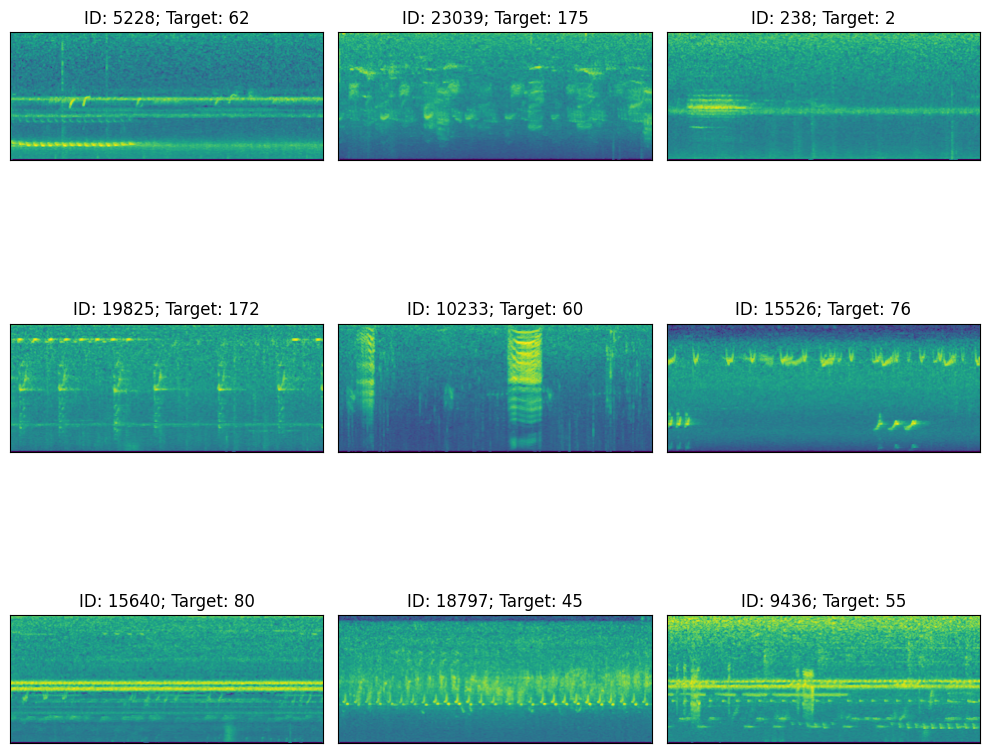

In [26]:
backaud = BackgroundAugmentation(0.1,0.1, ex_df, 'train')

dummy_dataset = BirdDataset( 
        train_df,
        back_augmentation = backaud,
        use_sumixup = True,
        spec_augmentation=get_transforms('train'),
        mode='train')

test_input, test_target= dummy_dataset[0]
print(test_input.detach().numpy().shape)

show_batch(dummy_dataset)


In [27]:
# test_target - test_target2

In [28]:
del dummy_dataset
gc.collect()

19511

In [29]:
train_df['maped'] = train_df.primary_label.map(train_df.primary_label.value_counts())
train_df.head(2)

,primary_label,sliced_path,wav_path,secondary_labels,rating,target,name,maped
0,asbfly,../../preprocessed_data/2024_30sec/data_2024_t...,../../data/2024/train_audio/asbfly/XC134896.ogg,[],5.0,0,..-XC134896,102
1,asbfly,../../preprocessed_data/2024_30sec/data_2024_t...,../../data/2024/train_audio/asbfly/XC164848.ogg,[],2.5,0,..-XC164848,102


In [30]:
train_df.shape

(24285, 8)

In [31]:
low_resource_labels = train_df.primary_label.value_counts().tail(19).index.values

In [32]:
# fixed_df = train_df[train_df['primary_label'].isin(low_resource_labels)].reset_index(drop=True)
# train_df = train_df[~train_df['primary_label'].isin(low_resource_labels)].reset_index(drop=True)

train_df.shape #, fixed_df.shape

(24285, 8)

In [33]:
from sklearn.model_selection import train_test_split
# Getting original splits
# kf = StratifiedKFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.seed)
train_df['fold'] = 0
tr, val = train_test_split(train_df, stratify=train_df.target, random_state=42, test_size = 0.12)

# for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y=train_df['target'])):
#     for idx in val_idx:
#         train_df.iloc[idx, train_df.columns.get_loc('fold') ] = fold

In [34]:
val.primary_label.nunique()

182

In [35]:
val['fold'] = 1

train_df = pd.concat([train_df, val]).reset_index(drop=True)
train_df.shape

(27200, 9)

In [36]:
# # # Reading additional data
# aug_df = pd.read_csv("past_competition_30sec_slices.csv")
# aug_df.head(2)

In [37]:
# aug_df['maped'] = aug_df.primary_label.map(aug_df.primary_label.value_counts())
# aug_df = aug_df[(aug_df.maped > 10) & (aug_df.maped < 500)]
# aug_df.primary_label.nunique()

In [38]:
# # # # Labels
# init_new_label = 182
# for p in aug_df.primary_label.unique():
#     if p not in label2id.keys():
#         label2id[p] = init_new_label
#         init_new_label+= 1
        
# id2label = dict(zip(label_id_list, label_list))

# aug_df = aug_df[['primary_label', 'sliced_path','secondary_labels','rating']].copy()  # Uses only audio, label and rating.

# # # Create Target
# aug_df['target'] = aug_df.primary_label.map(label2id)

In [39]:
# aug_df.target.value_counts()

In [40]:
# # # Getting augmented splits
# kf = StratifiedKFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.seed)
# aug_df['fold'] = 0
# for fold, (train_idx, val_idx) in enumerate(kf.split(aug_df, y=aug_df['target'])):
#     for idx in val_idx:
#         aug_df.iloc[idx, aug_df.columns.get_loc('fold') ] = fold

In [41]:
# train_df = pd.concat([train_df, aug_df]).reset_index(drop=True)
# train_df.fold.value_counts()

In [42]:
train_df.target.value_counts()

target
14     560
57     560
105    560
43     560
40     560
      ... 
178      7
16       7
5        6
92       6
119      6
Name: count, Length: 182, dtype: int64

In [43]:
for fold in train_df.fold.unique():
    print(train_df[train_df['fold']== fold].primary_label.nunique())

182
182


In [44]:
full_label_list = sorted(train_df['primary_label'].unique())
len(full_label_list)

182

In [45]:
from model_soup import XCAMetaBird


In [46]:
class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.backbone = XCAMetaBird(128,128,734)
        cpt = torch.load('./pre_trained_weights/xca_128emb_pastcompetition_mixup_cutmix/best_model_220968_61.pth', map_location='cpu')
        self.backbone.load_state_dict(cpt)

        self.backbone.classifier_layer = nn.Linear(128, 182)
        # self.classifier_layer = nn.Linear(734,182)
        # print(self.backbone)
    def forward(self, mel):
        return self.backbone(mel)

In [47]:
# cpt = torch.load('./pre_trained_weights/xca_128emb_pastcompetition_mixup_cutmix/best_model_220968_61.pth')
# cpt

In [48]:
n = MyModel()

x = torch.rand((2,128,313))
y = torch.randint(low=0, high=335, size=(1,1))[0]

pred = n(x)
pred.shape

torch.Size([2, 182])

In [49]:
del n 
gc.collect()

9

In [50]:
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler
from augment import Mixup, Cutmix
from lr_scheduler import CosineAnnealingWarmupRestarts
from loss import BCEFocalLoss


class BirdModel(pl.LightningModule):
    
    def __init__(self,steps_per_epoch):
        super().__init__()
        
        # == backbone ==
        # self.backbone = EffNet(CONFIG.model, n_classes=len(full_label_list))
        
        # self.backbone = MetaStyleEncoder(128,128,182)
        self.backbone = MyModel()
        self.steps_per_epoch = steps_per_epoch
        # == loss function ==
        self.loss_fn_surrogate = nn.BCEWithLogitsLoss(reduction="none")
        self.loss_fn = nn.CrossEntropyLoss(reduction="mean")
        self.loss_fn_focal = nn.BCEWithLogitsLoss(reduction="mean")
    
        self.mixup = Mixup(mix_beta=1.5)
        self.cutmix = Cutmix(1.5)
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=CONFIG.lr,
            weight_decay=CONFIG.weight_decay
        )

        # model_optimizer = Adan(self.parameters(), lr=CONFIG.lr, betas=(0.02, 0.08, 0.01), weight_decay=1e-2)
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=CONFIG.epochs,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )

        # lr_scheduler = CosineAnnealingWarmupRestarts(
        #     model_optimizer,
        #     first_cycle_steps= 2*CONFIG.epochs,
        #     cycle_mult=CONFIG.epochs,
        #     max_lr= CONFIG.lr,
        #     min_lr=1e-6,
        #     warmup_steps=0,
        #     gamma=1,
        #     last_epoch=-1
        # )
                
        # lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #     optimizer=model_optimizer, epochs=CONFIG.epochs,
        #     pct_start=0.0, steps_per_epoch=self.steps_per_epoch,
        #     max_lr=CONFIG.lr, div_factor=25, final_div_factor=4.0e-01
        # )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)

        
        # == pred ==
        y_pred = self(image)

        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)

        
        # == record ==
        self.log('ce', train_loss, True)

        return train_loss  

    # def backward(self, loss):
    #     loss.backward(retain_graph = True)
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach().float()
        
        # target to one-hot
#         target_val = torch.nn.functional.one_hot(target_val, len(label_list)).float()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val.to("cuda"), target_val.to("cuda"))
        
        
        target_val = np.ceil(target_val)
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=full_label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=full_label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

In [51]:
len(full_label_list)

182

In [52]:
torch.clamp(torch.tensor([-1,1,0]), min = 0)

tensor([0, 1, 0])

In [53]:
bird_model = BirdModel(steps_per_epoch = 999)

In [54]:
# bird_model.backward()

In [55]:
bird_model.current_epoch

0

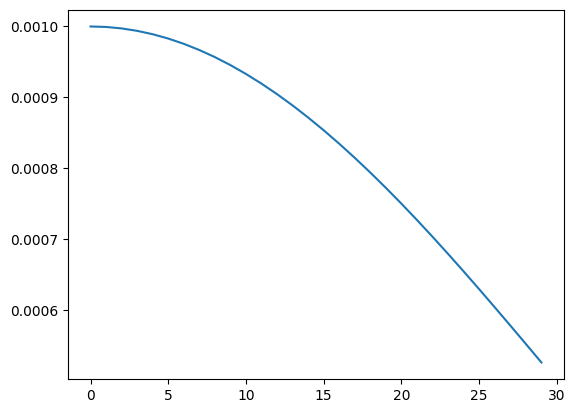

In [56]:
model_optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, MyModel().parameters()),
    lr=CONFIG.lr,
    weight_decay=CONFIG.weight_decay
)

# model_optimizer = Adan(self.parameters(), lr=CONFIG.lr, betas=(0.02, 0.08, 0.01), weight_decay=1e-2)

# == define learning rate scheduler ==
lr_scheduler = CosineAnnealingWarmupRestarts(
    model_optimizer,
    first_cycle_steps=30*2,
    cycle_mult=30*2,
    max_lr= CONFIG.lr,
    min_lr=1e-6,
    warmup_steps=0,
    gamma=1,
    last_epoch=-1
)

lrs = []
for i in range(30):
    lrs.append(lr_scheduler.get_lr())
    lr_scheduler.step()

plt.plot(lrs)

In [57]:
def predict(data_loader, model):
    model.to(CONFIG.device)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())

    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()

    # print(predictions.shape, gts.shape)
    #     gts = torch.nn.functional.one_hot(gts, len(label_list))
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

def predict_noised(val_df, model):
    backaud_valid = BackgroundAugmentation(0.1,0.1, ex_df_val, mode = 'eval')
    val_ds = BirdDataset(val_df, backaud_valid, False, get_transforms('valid'), 'valid')
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    mixup = Mixup(mix_beta=1)
    model.to(CONFIG.device)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(val_dl):
        with torch.no_grad():
            x, y = batch
            x, y = mixup(x, y)
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
#     gts = torch.nn.functional.one_hot(gts, len(label_list))
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [58]:
len(label_list)

182

In [58]:
full_label_list = label_list.copy()

In [59]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df[f'fold'] != 1].copy()
    valid_df = total_df[total_df[f'fold'] == 1].copy()


    # train_df = pd.concat([train_df, fixed_df]).reset_index(drop=True)
    # train_df = train_df[(train_df['rating'] >= 3)|(train_df['volumetry'] < 20)]
    print(f'There are {train_df.primary_label.nunique()} targets')

    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')

    # == create a sampler that samples inversely of its counts ==
    # y_train = train_df['target']
    # class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    # weight = 1. / class_sample_count
    # samples_weight = np.array([weight[t] for t in y_train])
    # samples_weight = torch.from_numpy(samples_weight)
    
    # sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    
    
    backaud = BackgroundAugmentation(0.1,0.5, ex_df_train)
    # backaud = None
#     backaud_valid = None
#     backaud_valid = BackgroundAugmentation(0.1,0.1, ex_df)
    
    train_ds = BirdDataset(train_df, None, False, get_transforms('train'), 'train')
    # train_ds = BirdDataset(train_df, backaud, True, None, 'train')
    # val_ds = BirdDataset(valid_df, None, False, get_transforms('valid'), 'valid')
    # train_ds = BirdDataset(train_df, None, False, None, 'train')
    val_ds = BirdDataset(valid_df, None, False, None, 'valid')
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CONFIG.batch_size,
        shuffle=True, # If using sampler must be False
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True,
        # sampler = sampler
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 4,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    bird_model = BirdModel(steps_per_epoch = len(train_dl))
    # bird_model = BirdModel()

    # Uncomment if fine tuning
    # print('loading pre trained')
    # cpt = torch.load(f'../chpks/30sec_effnet_frompretrained_5sec_samewaveaug_nobackground_overfitting_30epocas/fold_{fold_id}.ckpt', map_location=torch.device('cpu'))['state_dict']
    # bird_model.load_state_dict(cpt)
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=CONFIG.checkpoint_dir,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=CONFIG.epochs,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=False, # Default is True, but it doest not work with metastylespeech
        precision='16-mixed' if CONFIG.mix_precision else 32,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=full_label_list)
    pred_df = pred_df[label_list]
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=full_label_list)
    gt_df = gt_df[label_list]
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df.apply(np.ceil), pred_df, row_id_column_name='id')
    
    preds_noised, gts_noised = predict_noised(valid_df, bird_model)
    
    # = create dataframe =
    pred_df_noised = pd.DataFrame(preds_noised, columns=full_label_list)
    pred_df_noised = pred_df_noised[label_list]
    pred_df_noised['id'] = np.arange(len(pred_df_noised))
    gt_df_noised = pd.DataFrame(gts_noised, columns=full_label_list)
    gt_df_noised = gt_df_noised[label_list]
    gt_df_noised['id'] = np.arange(len(gt_df_noised))
    
    # = compute score =
    val_score_noised = score(gt_df_noised.apply(np.ceil), pred_df_noised, row_id_column_name='id')

    pd.DataFrame({f'val_noised': [val_score_noised], f'val_clean': [val_score]}).to_csv(f'{CONFIG.checkpoint_dir}/score_fold_{fold_id}.csv', index = False)
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in full_label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(full_label_list)*2)).astype(np.float32), columns=full_label_list+pred_cols)], axis=1)
    valid_df[full_label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{CONFIG.checkpoint_dir}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score, val_score_noised

In [60]:
# training
torch.set_float32_matmul_precision('high')

seed = CONFIG.seed
random.seed(seed)
torch.manual_seed(seed)

# record
fold_val_score_list = list()
fold_val_score_noised_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in full_label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=full_label_list+pred_cols)], axis=1)

for f in range(CONFIG.folds):
    
    # get validation index
    val_idx = list(train_df[train_df[f'fold'] == 1].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score, val_score_noised = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, full_label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)
    fold_val_score_noised_list.append(val_score_noised)
    print(f'Fold {f} Val Score: {fold_val_score_list[f]:.5f} Val Score Noised: {fold_val_score_noised_list[f]:.5f}')
    
for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f} Val Score Noised: {fold_val_score_noised_list[idx]:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{CONFIG.checkpoint_dir}/oof_pred.csv", index=False)

==== Running training for fold 0 ====
There are 182 targets
Train Samples: 24285
Valid Samples: 2915


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |                                                                                | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_129187/3344631845.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))
/tmp/ipykernel_129187/3344631845.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))
/tmp/ipykernel_129187/3344631845.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))
/tmp

Epoch 0:  50%|█████████████████████████▍                         | 379/759 [01:27<01:27,  4.33it/s, v_num=241, ce=2.270]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|█████████████████████████████████▉| 758/759 [03:18<00:00,  3.82it/s, v_num=241, ce=1.930, val_score=0.931]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1:  50%|████████████████▉                 | 379/759 [01:30<01:30,  4.18it/s, v_num=241, ce=2.010, val_score=0.954]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████▉| 758/759 [03:16<00:00,  3.85it/s, v_num=241, ce=1.980, val_score=0.965]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2:  50%|████████████████▉ 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████| 759/759 [03:42<00:00,  3.41it/s, v_num=241, ce=1.370, val_score=0.990]


  0%|                                                                                            | 0/23 [00:00<?, ?it/s]/tmp/ipykernel_129187/3344631845.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))
/tmp/ipykernel_129187/3344631845.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))
/tmp/ipykernel_129187/3344631845.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Using random background noise of unlabelled soundscapes


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:26<00:00,  1.74it/s]


Fold 0 Val Score: 0.98937 Val Score Noised: 0.62383
Fold 0 Val Score: 0.98937 Val Score Noised: 0.62383


In [ ]:
# pd.DataFrame({f'val_noised': [val_score_noised], f'val_clean': [val_score]}).to_csv(f'{CONFIG.checkpoint_dir}/score_fold_{0}.csv', index = False)

In [59]:
## replicating metrics of actual model but with the same pipeline as previous
PATH_TO = CONFIG.checkpoint_dir
# PATH_TO = '../chpks/exp0_5sec_xcamodel_selfmixup_3sumixup_mixup_cutmix_30epochs_3stages/'

seed = CONFIG.seed
random.seed(seed)
torch.manual_seed(seed)

for f in range(CONFIG.folds):
    eval_df = train_df[train_df[f'fold'] == f].copy()

    val_ds = BirdDataset(eval_df, None, False, get_transforms('valid'),'valid')
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    bird_model = BirdModel(12)
    best_model_path = PATH_TO + f'/fold_{f}.ckpt'
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)

    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=full_label_list)
    pred_df = pred_df[label_list]
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=full_label_list)
    gt_df = gt_df[label_list]
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df.apply(np.ceil), pred_df, row_id_column_name='id')
    
    preds_noised, gts_noised = predict_noised(eval_df, bird_model)
    
    # = create dataframe =
    # = create dataframe =
    pred_df_noised = pd.DataFrame(preds_noised, columns=full_label_list)
    pred_df_noised = pred_df_noised[label_list]
    pred_df_noised['id'] = np.arange(len(pred_df_noised))
    gt_df_noised = pd.DataFrame(gts_noised, columns=full_label_list)
    gt_df_noised = gt_df_noised[label_list]
    gt_df_noised['id'] = np.arange(len(gt_df_noised))
    
    # = compute score =
    val_score_noised = score(gt_df_noised.apply(np.ceil), pred_df_noised, row_id_column_name='id')

    print(f"Eval fold {f}: Val = {val_score}  Val noised = {val_score_noised}")

100%|█████████████████████████████████████████████████████████████████████████████████| 319/319 [02:45<00:00,  1.92it/s]


torch.Size([20391, 182]) torch.Size([20391, 830])


ValueError: Shape of passed values is (20391, 182), indices imply (20391, 830)

In [ ]:
ckpt_list = glob(f'{CONFIG.checkpoint_dir}/*.ckpt')
print(f'find {len(ckpt_list)} ckpts in {CONFIG.checkpoint_dir}.')
#ckpt_list = [ckpt_list[-1]]
ckpt_list

In [ ]:
# == setting of onnx ==

input_tensor = torch.randn(64, 128, 938)  # input shape
input_names = ['x']
output_names = ['output']

In [ ]:
onnx_ckpt_list = list()
for ckpt_path in ckpt_list:
    ckpt_name = os.path.basename(ckpt_path).split('.')[0]
    # == init model ==
    bird_model = MyModel()
    
    # == load ckpt ==
    weights = torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict']
    bird_model.load_state_dict(weights)
    bird_model.eval()
    
    # == convert to onnx ==
    torch.onnx.export(bird_model, input_tensor, f"{CONFIG.checkpoint_dir}/{ckpt_name}.onnx", verbose=False, input_names=input_names, output_names=output_names)
#     onnx_ckpt_list.append(f"{ckpt_name}.onnx")